## Шаг 1. Импорт и предобработка данных

Загружаем требуемые библиотеки

In [1]:
#common
import numpy as np
import pandas as pd 
import IPython
from IPython.display import display
import warnings
warnings.simplefilter('ignore')

#visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style

from statsmodels.tsa.seasonal import seasonal_decompose

# ML
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from catboost import CatBoostRegressor, Pool
import xgboost as xgb

Загружаем данные

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Исходный датасет содержит 26496 наблюдений, временной интревал наблюдений составляет 10 минут.  
Пропущенных значений нет.  
При первичном анализе установлено, что временной промежуток данных длится с 1 марта 2018 года по 31 августа 2018 года. Проверим монотонность даты (индекса).

In [5]:
if taxi.index.is_monotonic == True :
    print('Даты расположены в хронологическом порядке')
else:
    print('Требуется предобработка')

Даты расположены в хронологическом порядке


Хорошо, проблем с датами пока не обнаружено.  
Необходимо ресемплировать данные по 1 часу.

In [6]:
taxi = taxi.resample('1H').sum()
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Анализ данных и временных рядов проведем на следующем шаге.

### Вывод  

На данном шаге были загружены данные и требуемые библиотеки.  
Первичный анализ временных рядов не выявил аномалий и пропущенных значений. Данные о числе заказов также не содержат пропусков. 

---

## 2. Анализ данных

Проверим распределение заказов.

In [7]:
taxi.sort_values(by='num_orders')

,num_orders
datetime,
2018-04-06 06:00:00,0
2018-04-05 06:00:00,1
2018-03-09 05:00:00,1
2018-04-03 06:00:00,1
2018-04-24 06:00:00,2
...,...
2018-08-27 04:00:00,295
2018-08-30 17:00:00,342
2018-08-27 02:00:00,408


462 заказа в 2 часа ночи 20 августа - люди прилетают с отпусков. И полное отсутсвие в 6 утра 6 апреля - никому никуда не нужно.  В целом - отрицательных и сверх-огромных значений не замечено.  
Посмотрим на диаграмму распределения.

Медианное значение заказов =  78.0


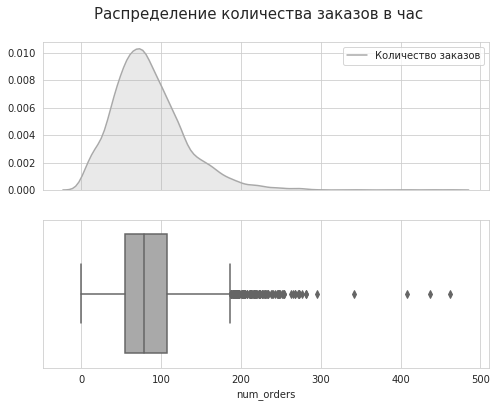

In [8]:
sns.set_style('whitegrid')

fig, axes = plt.subplots(2,1,sharex=True, figsize=(8,6))

sns.kdeplot(taxi['num_orders'], color='darkgrey', shade=True, label='Количество заказов', ax=axes[0])
sns.boxplot(taxi['num_orders'], orient='h', color='darkgrey')

plt.suptitle('Распределениe количества заказов в час', size=15, y=(0.96));

print('Медианное значение заказов = ', taxi['num_orders'].median())

Чаще всего в час поступает в районе 78 заказов.  

#### Анализ временных рядов

Проверим, к какому типу принадлежит наш временной ряд.

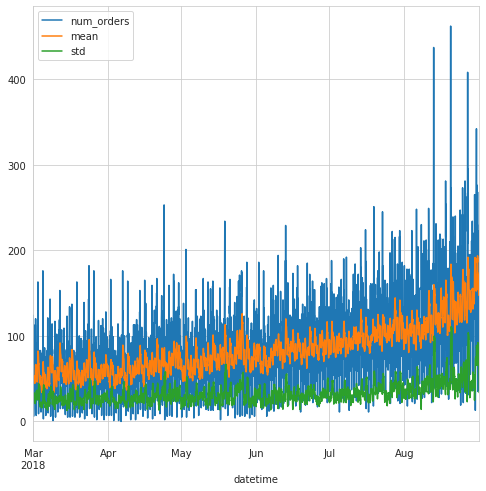

In [11]:
taxi['mean'] = taxi['num_orders'].rolling(15).mean()
taxi['std'] = taxi['num_orders'].rolling(15).std()

taxi.plot(figsize=(8,8));

Скользящее среднее отклонение со временем изменяеся не слишком сильно. При этом среднее значение - достаточно высоко поднимется в августе. Из этого следует, что перед нами - нестационарный временной ряд.  

Изучим тренд и сезонность.

In [12]:
taxi = taxi.drop(['mean','std'], axis=1)

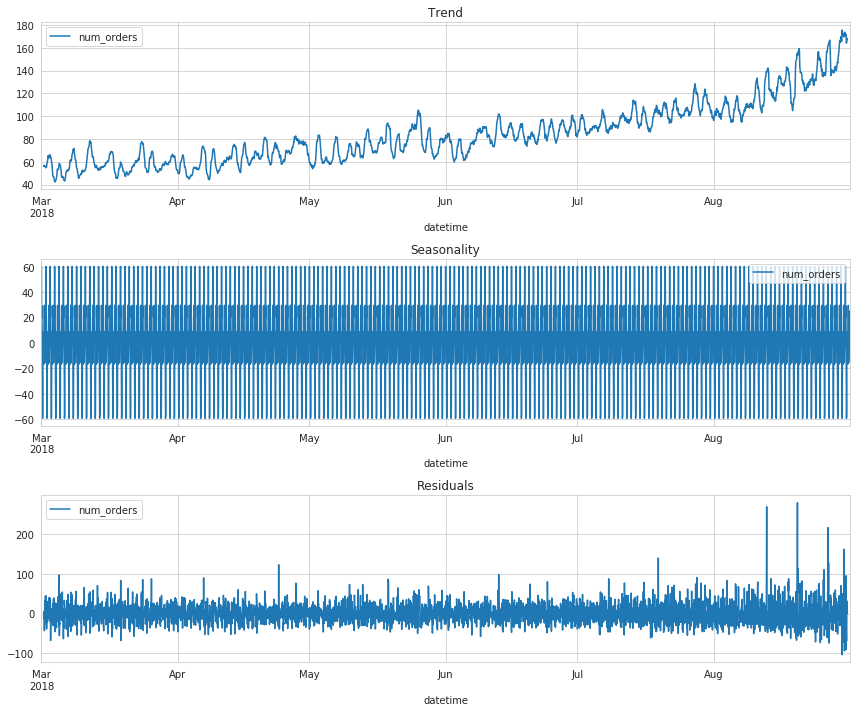

In [13]:
decomposed = seasonal_decompose(taxi)

plt.figure(figsize=(12, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

На данном графике заметен глобальный тренд увеличения числа заказов такси на протяжении всего изучаемого периода.  
Колебяния сезонности на данном графике изучить невозможно, попробуем увеличить масштаб.  
Посмотрим на два разных месяца - апрель и август и первые трое суток.

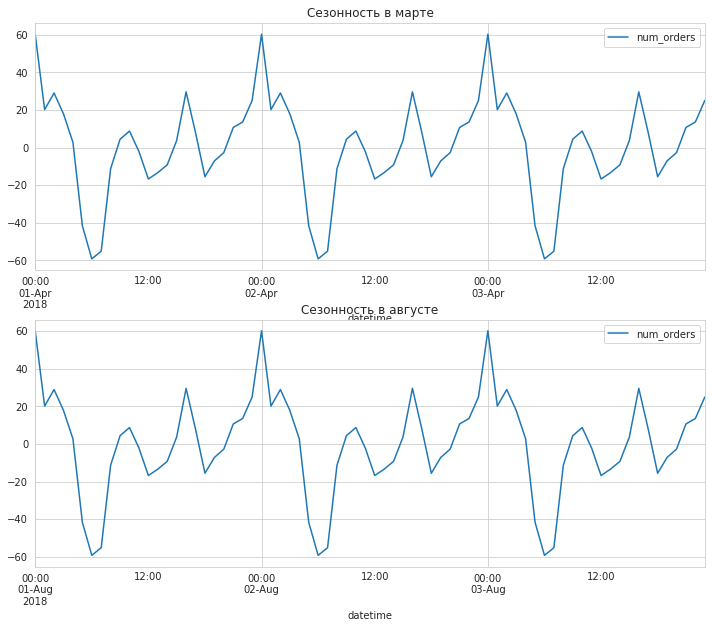

In [14]:
plt.figure(figsize=(12, 10))

plt.subplot(211)
decomposed.seasonal['2018-04-01':'2018-04-03'].plot(ax=plt.gca())
plt.title('Сезонность в марте')
plt.subplot(212)
decomposed.seasonal['2018-08-01':'2018-08-03'].plot(ax=plt.gca())
plt.title('Сезонность в августе');

Больше всего заказов такси приходится на 00 часов. Выскажу предположение о том, что в этот момент прилетает много самолетов и отсустствует дополнительный наземный транспорт, которым можно добраться из аэропорта.  
Минимальное количество заказов в районе 6-7 часов утра.  
Так же заметен второй по величине пик заказов в районе 16-17 дня.  

Выдвину гипотезу о том, что на основании текущих данных, именно в эти моменты компании "Четенькое такси" необходимо увеличивать количество водителей на маршрутах.  

Текущий анализ данных завершен, переходим к выводам.

### Вывод  

На данном этапе был произведен анализ исходных данных. За время исследования обнаружены следующие особенности:  
1. Чаще всего за час в службу такси поступают 78 заказов,  
2. На протяжении всего года заметен тренд к увеличению количество заказов,  
3. Обнаружена "сезонность" загруженности: пиковые часы приходятся на 00 и 16-17 часов вечера,  
4. Минимальная загрузка наблюдается в течение часа, с 6 до 7 утра, так же две небольшие просадки количества заказов заметны в 12 и 18 часов.

На основании первичных полученных данных можно предположить о необходимости усиления рабочих смен таксистов именно указанные выше часы.  

Переходим к более точному прогнозированию и обучению моделей.

---

## 3. Подбор и обучение моделей

**feature engeneering**  

Создадим дополнительные признаки в исходном сете для лучшего обучения моделей.  

На вход функция принимает датасет, количество "шагов" для отстающий значений и скользящее среднее без учета текущего значения количества заказов.  
Новые признаки так же определяются, как месяц, день, день недели и час.

In [15]:
def new_features(data, max_lag, rolling_mean_size):
    
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [16]:
new_features(taxi, 10,10)

In [17]:
taxi.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,rolling_mean
datetime,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


У нас остаются пропущенные значения, но их не так много и они будут удалены после разбития на выборки.  

---

**Создание подвыборок**  

Разобьем датасет на обучающую, валидационную и тестовую выборку.

In [18]:
sub, test = train_test_split(taxi, test_size=.1, shuffle=False)
train, valid = train_test_split(sub, test_size=.1, shuffle=False)

In [19]:
train.dropna(inplace=True)

In [20]:
train.shape[0], valid.shape[0], test.shape[0]

(3566, 398, 442)

Разбиваем фичи на признаки и целевой признак

In [21]:
X_train = train.drop(['num_orders'], axis=1)
X_valid = valid.drop(['num_orders'], axis=1)
X_test = test.drop(['num_orders'], axis=1)

y_train = train['num_orders']
y_valid = valid['num_orders']
y_test = test['num_orders']

---

**Проверка моделей на адекватность**  

Попробуем предсказать временной период медианный значеним и посмотрим, какого качества метрики rmse мы сможем добиться.  
(далее все модели в данном разделе будем тестировать только на валидационной выборке)

In [22]:
y_valid_med = np.ones(y_valid.shape) * y_train.median()
y_test_med = np.ones(y_test.shape) * y_train.median()

print("RMSE valid:", mean_squared_error(y_valid, y_valid_med)**0.5)
print("RMSE test:", mean_squared_error(y_test, y_test_med)**0.5)

RMSE valid: 60.16539181173257
RMSE test: 89.39768286346948


Отклоняемся на 89 заказов на тестовой выборке. Не самый радужный результат.  

---

**Подбор и тестирование моделей**

Попробуем применить простенькую логистическую регрессию.

In [23]:
%%time
lr = LinearRegression().fit(X_train, y_train)

CPU times: user 5.89 ms, sys: 131 µs, total: 6.02 ms
Wall time: 3.68 ms


In [24]:
def prediction(model, feat, targ):
    
    pred = model.predict(feat)
    rmse = mean_squared_error(pred, targ)**0.5
    
    return(rmse)

In [25]:
%%time

prediction(lr, X_valid, y_valid)

CPU times: user 7.66 ms, sys: 566 µs, total: 8.23 ms
Wall time: 2.01 ms


40.57041300704119

Лучше, чем дамми моделька.  
Сразу создадим табличку, в которую будем вносить полученые данные

In [26]:
res = {
    'model_name':pd.Series(['LogReg','KNN','LinSVM','GradBoost','CatBoost']),
    'training_time':pd.Series([5.75]),
    'prediction_valid_time':pd.Series([3.52]), 
    'rmse_valid':pd.Series([40.57]), 
    'prediction_test_time':pd.Series([]), 
    'rmse_test':pd.Series([])}

results = pd.DataFrame(res)
results

,model_name,training_time,prediction_valid_time,rmse_valid,prediction_test_time,rmse_test
0,LogReg,5.75,3.52,40.57,NaN,NaN
1,KNN,NaN,NaN,NaN,NaN,NaN
2,LinSVM,NaN,NaN,NaN,NaN,NaN
3,GradBoost,NaN,NaN,NaN,NaN,NaN
4,CatBoost,NaN,NaN,NaN,NaN,NaN


---

**Ближайшие соседи**  

Вспомним по класс моделей, которые мы не использовали достаточно давно. Для применения данной и следующей модели нам необходимо скалировать данные. К работе с соседями применим MinMax преобразование.

In [27]:
min_max = MinMaxScaler()

min_max.fit(X_train)

X_train_mm = min_max.transform(X_train)
X_valid_mm = min_max.transform(X_valid)
X_test_mm = min_max.transform(X_test)

Напишем функцию серча гиперпараметров.

In [28]:
def grid(model, params, feat, targ):
    
    search = GridSearchCV(model, params, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
    search.fit(feat, targ)
    
    print('Best score = ', search.best_score_)
    print(search.best_params_)

Создаем базовую модель и сетку гиперпараметров.

In [29]:
knn = KNeighborsRegressor()

knn_params = dict(n_neighbors=range(3,10),
                   metric=['minkowski', 'manhattan'],
                   leaf_size=[20,25,30,35],
                   algorithm=['auto','ball_tree','kd_tree'])

In [30]:
grid(knn, knn_params, X_train_mm, y_train)

Best score =  -603.2826454235129
{'algorithm': 'auto', 'leaf_size': 20, 'metric': 'manhattan', 'n_neighbors': 9}


In [31]:
knn = KNeighborsRegressor(algorithm='auto', leaf_size=20, metric='manhattan', n_neighbors=8)

In [32]:
%%time
knn.fit(X_train_mm, y_train)

CPU times: user 3.64 ms, sys: 0 ns, total: 3.64 ms
Wall time: 3.29 ms


KNeighborsRegressor(algorithm='auto', leaf_size=20, metric='manhattan',
                    metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                    weights='uniform')

In [33]:
%%time
prediction(knn, X_valid_mm, y_valid)

CPU times: user 44.8 ms, sys: 9 µs, total: 44.9 ms
Wall time: 63.4 ms


35.57724472660416

In [34]:
results.loc[1, 'training_time'] = 3.64
results.loc[1, 'prediction_valid_time'] = 0.43
results.loc[1,'rmse_valid'] = 35.58

In [35]:
results.head()

,model_name,training_time,prediction_valid_time,rmse_valid,prediction_test_time,rmse_test
0,LogReg,5.75,3.52,40.57,NaN,NaN
1,KNN,3.64,0.43,35.58,NaN,NaN
2,LinSVM,NaN,NaN,NaN,NaN,NaN
3,GradBoost,NaN,NaN,NaN,NaN,NaN
4,CatBoost,NaN,NaN,NaN,NaN,NaN


Улучшили метрику на валидационной выборке, однако, увеличили время предсказания.

---

**Linear Support Vector Regressor**  

Еще один класс линейных моделей. Как оказалось, достаточно мощно и быстро может обрабатывать большие массивы данных. Однако, у нас есть слишком сильно отклоняющие значения и прогноз на тестовой выборке может быть не слишком точным.  

В данном случае скалируем данные с помощью StandardScaler

In [36]:
st_sc = StandardScaler()

st_sc.fit(X_train)

X_train_ss = st_sc.transform(X_train)
X_valid_ss = st_sc.transform(X_valid)
X_test_ss = st_sc.transform(X_test)

In [37]:
svm = LinearSVR(random_state=42)

svm_params = dict(max_iter=[100,500,1000,1200,1500],
                  C=[0.1,0.5,1],
                  tol=[1e-3, 1e-4, 1e-5])

In [38]:
grid(svm, svm_params, X_train_ss, y_train)

Best score =  -886.0742064385465
{'C': 1, 'max_iter': 100, 'tol': 1e-05}


In [39]:
svm = LinearSVR(random_state=42, C=1, max_iter=100, tol=0.0001)

In [40]:
%%time
svm.fit(X_train_ss, y_train)

CPU times: user 9.26 ms, sys: 140 µs, total: 9.4 ms
Wall time: 8.64 ms


LinearSVR(C=1, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=100,
          random_state=42, tol=0.0001, verbose=0)

In [41]:
%%time
prediction(svm, X_valid_ss, y_valid)

CPU times: user 1.07 ms, sys: 165 µs, total: 1.23 ms
Wall time: 984 µs


41.31250816813142

In [42]:
results.loc[2, 'training_time'] = 8.54
results.loc[2, 'prediction_valid_time'] =1
results.loc[2,'rmse_valid'] = 41.31

In [43]:
results

,model_name,training_time,prediction_valid_time,rmse_valid,prediction_test_time,rmse_test
0,LogReg,5.75,3.52,40.57,NaN,NaN
1,KNN,3.64,0.43,35.58,NaN,NaN
2,LinSVM,8.54,1.00,41.31,NaN,NaN
3,GradBoost,NaN,NaN,NaN,NaN,NaN
4,CatBoost,NaN,NaN,NaN,NaN,NaN


Самое быстрое время предсказания, но и самые слабые предсказания.  
Попробуем градиент буст.  

---

**Gradient Boosting Regressor**  

Данный класс модели не требует у нас скалирования данных. Переходим сразу к подбору гиперпараметров и обучению.  

Поиск параметров проводим в 2 этапа - сначала подбираем лучшее количество деревьев, затем - остальные параметры.

In [44]:
gbr = GradientBoostingRegressor(random_state=42)

gbr_params_est = dict(n_estimators=range(100,1000,10))

gbr_params_other = dict(learning_rate=[0.1,1],
                        max_depth=[2,3,4,5],
                        min_samples_split=[2,3,4], 
                        tol=[1e-3, 1e-4, 1e-5])

In [45]:
#grid(gbr, gbr_params_est, X_train, y_train)

Best score =  -537.2349881751834  
{'n_estimators': 200}

In [46]:
gbr = GradientBoostingRegressor(random_state=42, n_estimators=200)

In [47]:
#grid(gbr, gbr_params_other, X_train, y_train)

Best score =  -526.0770425387703  
{'learning_rate': 0.1, 'max_depth': 4, 'min_samples_split': 4, 'tol': 0.001}

In [48]:
gbr = GradientBoostingRegressor(random_state=42, 
                                n_estimators=200, learning_rate=0.15, max_depth=4, min_samples_split=4, tol=0.001)

In [49]:
%%time
gbr.fit(X_train, y_train)

CPU times: user 785 ms, sys: 0 ns, total: 785 ms
Wall time: 816 ms


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.15, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=4,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [50]:
%%time
prediction(gbr, X_valid, y_valid)

CPU times: user 5.09 ms, sys: 0 ns, total: 5.09 ms
Wall time: 4.21 ms


32.11916675544369

In [51]:
results.loc[3, 'training_time'] = 2230
results.loc[3, 'prediction_valid_time'] = 7.99
results.loc[3,'rmse_valid'] = 32.88

results

,model_name,training_time,prediction_valid_time,rmse_valid,prediction_test_time,rmse_test
0,LogReg,5.75,3.52,40.57,NaN,NaN
1,KNN,3.64,0.43,35.58,NaN,NaN
2,LinSVM,8.54,1.00,41.31,NaN,NaN
3,GradBoost,2230.00,7.99,32.88,NaN,NaN
4,CatBoost,NaN,NaN,NaN,NaN,NaN


Самое долгое время предсказания, но  на текущий момент - самое лучшее.  

Посмотрим, как справится catboost.

---

**CatBoost Regressor** 

Создадим список категориальных фичей.

In [52]:
taxi.columns

Index(['num_orders', 'month', 'day', 'dayofweek', 'hour', 'lag_1', 'lag_2',
       'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10',
       'rolling_mean'],
      dtype='object')

In [53]:
cat_features = ['month', 'day', 'dayofweek', 'hour']

Создаем пулы, обучаем и тестируем модель.

In [54]:
catboost_train = Pool(X_train, y_train, cat_features=cat_features)

In [55]:
catboost = CatBoostRegressor(
                          iterations=300, 
                          depth=4, 
                          learning_rate=0.3, 
                          loss_function='RMSE', 
                          subsample=0.9,
                          #grow_policy='Depthwise',
                          ###
                          verbose=0, 
                          random_seed=42)

In [56]:
%%time
catboost.fit(catboost_train)

CPU times: user 6.41 s, sys: 1.28 s, total: 7.69 s
Wall time: 11.6 s


In [66]:
%time
prediction(catboost, X_valid, y_valid)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 7.87 µs


36.825092357881424

Попробуем пробежаться хайпероптом по гиперпараметрам.

In [58]:
# ! pip install hyperopt

*Ячейка ниже переведена в маркдаун*

import hyperopt
import catboost as ctb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials, hp

ctb_reg_params = {
    'learning_rate':  hp.quniform('learning_rate', 0.1, 0.6, 0.1),
    'max_depth': hp.quniform('max_depth', 1, 6, 1),
    'n_estimators': hp.quniform('n_estimators', 100, 800, 10),
    'eval_metric': 'RMSE',
    #'grow_policy':'Depthwise',
    'subsample': hp.quniform('subsample', 0.3, 0.9, 0.1), 
    'random_seed':42
}

ctb_fit_params = {
    #'early_stopping_rounds': 10,
    'verbose': False,
}

ctb_para = dict()
ctb_para['reg_params'] = ctb_reg_params
ctb_para['fit_params'] = ctb_fit_params
ctb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

class HPOpt(object):    

    def __init__(self, x_train, x_test, y_train, y_test):
        self.x_train = x_train
        self.x_test  = x_test
        self.y_train = y_train
        self.y_test  = y_test    
        
    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials    
    
    def ctb_reg(self, para):
        
        reg = ctb.CatBoostRegressor(**para['reg_params'])
        return self.train_reg(reg, para)   
    
    def train_reg(self, reg, para):
        reg.fit(self.x_train, self.y_train,
                eval_set=[(self.x_train, self.y_train), (self.x_test, self.y_test)],
                **para['fit_params'])
        pred = reg.predict(self.x_test)
        loss = para['loss_func'](self.y_test, pred)
        return {'loss': loss, 'status': STATUS_OK}
    
obj =  HPOpt(X_train, X_valid, y_train, y_valid)
ctb_opt = obj.process(fn_name='ctb_reg', space=ctb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

In [59]:
#ctb_opt

({'learning_rate': 0.5,
  'max_depth': 3.0,
  'n_estimators': 250.0,
  'subsample': 0.5}

In [60]:
cbr  = CatBoostRegressor(
                          iterations=250, 
                          depth=3, 
                          learning_rate=0.5, 
                          loss_function='RMSE', 
                          subsample=0.5,
                          verbose=0, 
                          random_seed=42)

In [61]:
%%time
cbr.fit(catboost_train)

CPU times: user 3.63 s, sys: 632 ms, total: 4.26 s
Wall time: 10.3 s


In [62]:
%%time
prediction(cbr, X_valid, y_valid)

CPU times: user 6.36 ms, sys: 3.26 ms, total: 9.62 ms
Wall time: 4.27 ms


38.91386682026677

Параметры, найденные вручную (выше, до хайперопта), оказались лучше. Буду дальше изучать этот метод поиска.

In [67]:
results.loc[4, 'training_time'] = 7690
results.loc[4, 'prediction_valid_time'] = 0.7
results.loc[4,'rmse_valid'] = 36.83

results

,model_name,training_time,prediction_valid_time,rmse_valid,prediction_test_time,rmse_test
0,LogReg,5.75,3.52,40.57,NaN,NaN
1,KNN,3.64,0.43,35.58,NaN,NaN
2,LinSVM,8.54,1.00,41.31,NaN,NaN
3,GradBoost,2230.00,7.99,32.88,NaN,NaN
4,CatBoost,7690.00,0.70,36.83,NaN,NaN


 Не самые лучшие показатели. Завершаем данный шаг выводами.

### Вывод  

На данном этапе было протестировано 5 моделей. Обучение проводилось на подвыборке train, валидация - на подвыборке valid.  
Все исследуемые модели продемонстрировали лучший, чем дамми моделька, показатель метрики rmse.  
На текущий момент лучшей моделью по качеству является градиентный регрессор sklearn, худшей - саппорт вектор. Градиентные ансамбли, в сравнении с обычными моделями обучаются в несколько раз дольше, что, в целом, объяснимо и понятно.  
Можно отбросить логистическую регрессию и саппорт вектор, однако, для полноты исследования протестируем все представленные модели на следующем шаге.

---

## 4. Тестирование моделей

In [64]:
sub_upd = sub.dropna()

In [69]:
feat = sub_upd.drop(['num_orders'], axis=1)
targ = sub_upd['num_orders'] 


feat_mm = min_max.transform(feat)
feat_ss = st_sc.transform(feat)

In [70]:
catboost_full = Pool(feat, targ, cat_features=cat_features)

Тестируем модели

*LogReg*

In [72]:
%%time
lr.fit(feat, targ)

CPU times: user 7.47 ms, sys: 508 µs, total: 7.98 ms
Wall time: 4.58 ms


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [73]:
%%time
prediction(lr, X_test, y_test)

CPU times: user 2.84 ms, sys: 0 ns, total: 2.84 ms
Wall time: 2.31 ms


53.454643856732545

In [74]:
results.loc[0, 'prediction_test_time'] = 2.31
results.loc[0,'rmse_test'] = 53.45

*knn*

In [75]:
%%time
knn.fit(feat_mm, targ)

CPU times: user 5.37 ms, sys: 171 µs, total: 5.54 ms
Wall time: 4.26 ms


KNeighborsRegressor(algorithm='auto', leaf_size=20, metric='manhattan',
                    metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                    weights='uniform')

In [97]:
%%time
prediction(knn, X_test_mm, y_test)

CPU times: user 63.3 ms, sys: 0 ns, total: 63.3 ms
Wall time: 61.4 ms


52.142250311373566

In [83]:
results.loc[1, 'prediction_test_time'] = 58.7
results.loc[1,'rmse_test'] = 52.14

*svm*

In [78]:
%%time
svm.fit(feat_ss, targ)

CPU times: user 14.1 ms, sys: 198 µs, total: 14.3 ms
Wall time: 12.4 ms


LinearSVR(C=1, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=100,
          random_state=42, tol=0.0001, verbose=0)

In [79]:
%%time
prediction(svm, X_test_ss, y_test)

CPU times: user 1.4 ms, sys: 0 ns, total: 1.4 ms
Wall time: 1.14 ms


54.22170516535908

In [94]:
results.loc[2, 'prediction_test_time'] = 1.4
results.loc[2,'rmse_test'] = 54.22

*GradBoost*

In [81]:
%%time
gbr.fit(feat, targ)

CPU times: user 904 ms, sys: 0 ns, total: 904 ms
Wall time: 906 ms


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.15, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=4,
                          min_weight_fraction_leaf=0.0, n_estimators=200,
                          n_iter_no_change=None, presort='auto',
                          random_state=42, subsample=1.0, tol=0.001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [82]:
%%time
prediction(gbr, X_test, y_test)

CPU times: user 4.69 ms, sys: 0 ns, total: 4.69 ms
Wall time: 4.22 ms


45.647131344235724

In [85]:
results.loc[3, 'prediction_test_time'] = 4.69
results.loc[3,'rmse_test'] = 45.65

*CatBoost*

In [86]:
%%time
catboost.fit(catboost_full)

CPU times: user 6.6 s, sys: 1.28 s, total: 7.88 s
Wall time: 11.9 s


In [87]:
%%time
prediction(catboost, X_test, y_test)

CPU times: user 8.12 ms, sys: 3.55 ms, total: 11.7 ms
Wall time: 5.98 ms


43.715785998890006

In [88]:
results.loc[4, 'prediction_test_time'] = 11.7
results.loc[4,'rmse_test'] = 43.72

Посмотрим на общие результаты.

In [95]:
results

,model_name,training_time,prediction_valid_time,rmse_valid,prediction_test_time,rmse_test
0,LogReg,5.75,3.52,40.57,2.31,53.45
1,KNN,3.64,0.43,35.58,58.70,52.14
2,LinSVM,8.54,1.00,41.31,1.40,54.22
3,GradBoost,2230.00,7.99,32.88,4.69,45.65
4,CatBoost,7690.00,0.70,36.83,11.70,43.72


In [96]:
sort = results.sort_values(by='rmse_test')
sort

,model_name,training_time,prediction_valid_time,rmse_valid,prediction_test_time,rmse_test
4,CatBoost,7690.00,0.70,36.83,11.70,43.72
3,GradBoost,2230.00,7.99,32.88,4.69,45.65
1,KNN,3.64,0.43,35.58,58.70,52.14
0,LogReg,5.75,3.52,40.57,2.31,53.45
2,LinSVM,8.54,1.00,41.31,1.40,54.22


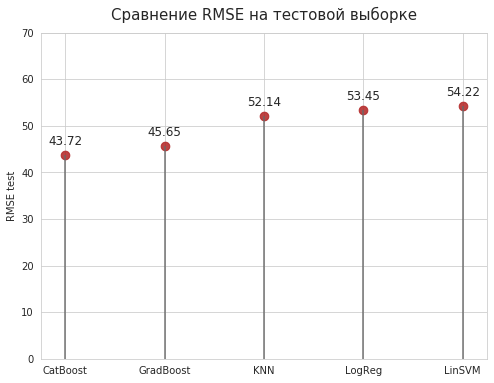

In [146]:
fig, ax = plt.subplots(figsize=(8,6))
ax.vlines(x=sort['model_name'], ymin=0, ymax=sort['rmse_test'], color='dimgrey', alpha=0.7, linewidth=2)
ax.scatter(x=sort['model_name'], y=sort['rmse_test'], s=75, color='firebrick', alpha=0.85)

ax.set_title('Сравнение RMSE на тестовой выборке', size=15, y=(1.02))
ax.set_ylabel('RMSE test')
ax.set_ylim(0, 70)

for row in sort.itertuples():
    ax.text(row.model_name, row.rmse_test+1.5, s=row.rmse_test,
            horizontalalignment= 'center', verticalalignment='bottom', fontsize=12)
  
plt.show()

В ходе анализа было установлено, что только 2 модели смогли продемонстрировать показатель, который удовлетворяет требование по размеру RMSE - это CatBoost и GradientBoostingRegressor. 
Однако стоить заметить, что данные модели требуют гораздо большего времени обучения, по сравнению с остальными представителями регрессоров в настоящем исследовании.  

Переходим к выводам и финальному выводу.

---

### Вывод 

На данном этапе производилось измерение качества предсказаний на тестовой выборке.  
По результатам исследования к применению в реальной работе рекомендуются catboost и gradientboosting. Они продемонстрировали rmse на тестовой выборке 43.72 и 45.65 пунктов соответственно. Время обучения предложенных моделей составляет 4 и 1 секунды, что стоит учитывать при работе с гораздо бОльшими источниками данных.  
В рамках текущей задачи rmse = 43 считается допустимой, однако, для более качественного прогноза стоит поискать более полные данные, с большим, вероятно, количеством признаков.  

---

## Общий вывод  

Целью настоящего исследования ставилось создание модели, способной предсказать спрос на услуги такси с отклонением до 48 заказов в час.  

Результатом тестовых испытаний стали 2 модели, прошедшие установленный порог - catboost и gradietboosting, c показателями 43,72 и 45,65б соответственно.  

Также в ходе исследования были протестированы 3 модели - логистическая регрессия, ближайшие соседи и регрессия с опорными векторами, однако ни одна из них не смогла пересечь рубеж в 48 rmse на тестовой выборке.  

Отчасти это связано с тем, что в тестовом сепле мы можем наблюдать повышенную дисперсию и общий тренд на увеличение заказов, которые сложно прогноризуются в "начале" сезона. Отчасти именно с этим и связано решение на шаге 4 - обучать модели на максимально полных данных, соединив обучающую и валидационную выборки.  

В остальном - данные так же показывают заметную сезонность-  пиковые нагрузки приходятся на 00 и 16-17 часов, тогда как минимальное количество заказов поступает ранним утром (6-7 часов) и в 18 часов вечера.  На основании этих данных можно создать рекомендацию о дополнительном увеличении количества экипажей такси именно в эти часы.  

Цели и задачи исследования достигнуты, однако для улучшения метрики стоит взять больший период времени или найти дополнительные фичи (вопрос к тимлиду и более опытным коллегам.